In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Cargamos los datos

In [3]:
data = pd.read_csv('dataset_kickstarter_ml.csv', sep=';')

In [10]:
data_filtered= data[ (data['country'] =='ES') & (data['goal'] <=100000) & (data['pledged'] <=100000) ]

In [12]:
data= data_filtered.loc[:, ('ID','goal', 'pledged')]

In [46]:
data_final= data.copy()

,goal,pledged,Cluster ID
0,6000.0,2.00,0
1,13500.0,15129.00,1
2,23800.0,1459.28,2
3,4500.0,22.50,0
4,5220.0,0.00,0


# EDA 

A continuación vamos a realizar una exploración de las dos variables que vamos a usar para crear el clustering. En este caso nos centramos en 'goal' y 'pledged'. 

In [14]:
data_final.describe()

,goal,pledged
count,337508.000000,337508.000000
mean,8045.195106,2071.827246
std,10703.302867,3476.765570
min,0.009000,0.000000
25%,1800.000000,27.000000
50%,4500.000000,472.500000
75%,9000.000000,2470.500000
max,64665.900000,18454.752000


Tras observar las principales métricas estadísticas podemos decir que la variable 'goal' presenta un rango entre 0 y 65.000 euros aproximadamente.La variable 'pledged' presenta un rango entre 0 y 18.000.

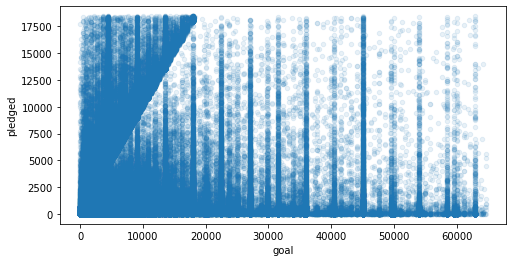

In [15]:
data_final.plot(kind="scatter",
                                x="goal",
                                y="pledged",
                                alpha=0.1,          

                                figsize=(8,4)
                               )

Tras visualizar el gráfico podemos observar que el mayor número de observaciones se concentran en aquellos valores de 'goal' menores a 20.000 euros. Sin embargo, en cuanto a la variable 'pledged' vemos que los valores se distirbuyen mayoritariamente a lo largo de todo su rango,con un mayor número de observaciones en el rango entre 0 y 10.000. 
Se observa que para aquellos valores de 'goal' superiores a 20.000 tienen un menor número de proyectos y la inversión que se ha realizado en ellos varía a lo largo de todo el eje 'y' observandose una mayor concentración en los valores pequeños de 'pledged' donde se ve un color azul más 'tupido' debido a una mayor concentración de proyectos en esos valores.

# Algoritmo K-Means

Para hacer una mejor aproximación de los grupos que usaremos para realizar el clustering, vamos a usar la técnica de Elbow. Se probarán entre 1 y 10 clusters y veremos su respectivo valor de WSSE. Posteriormente elegiremos el númeor de clusters que presenta un menor valor para WSSE

In [37]:
numeros_de_k = []
wsses = []

for numero_de_k in range(1, 10):
    
    
    kmeans = KMeans(n_clusters=numero_de_k, 
                    random_state=112)
    
    # Creamos un pipeline e incluímos el estandarizador
    pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                               ("kmeans", kmeans)])
    
    # Ajustamos el modelo a las dos variables que vamos a usar
    pipeline.fit(data_final[["goal", "pledged"]])
 
    # extraigo el modelo k-means
    kmeans_extraido = pipeline.steps[-1][1]
    
    # extraigo el valor de WSSE del modelo k-means 
    wsse = kmeans_extraido.inertia_
    
    # Añano el número de clusters y los correspondientes valores del WSSE a la lista
    numeros_de_k.append(numero_de_k)
    wsses.append(wsse)
    

A continuación creamos un dataframe en donde podemos ver con mayor claridad el número de cluster y su valor WSSE

In [38]:
df_clusters_wsse= pd.DataFrame({'num_clusters': numeros_de_k,
                              'WSSE':wsses})
df_clusters_wsse

,num_clusters,WSSE
0,1,675016.000000
1,2,409264.749786
2,3,191272.266821
3,4,143996.071352
4,5,98787.279148
5,6,82173.397785
6,7,68418.372466
7,8,57160.285334
8,9,50196.789082


#### Representación gráfica del método Elbow

Text(0, 0.5, 'WSSE')

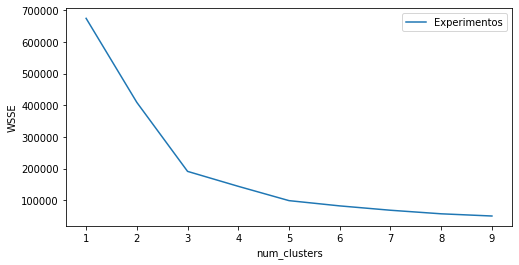

In [39]:
import matplotlib.pyplot as plt
df_clusters_wsse.plot(kind='line',
                     x="num_clusters",
                     y='WSSE',
                     label='Experimentos',
                     figsize=(8,4))

plt.xticks(range(1, len(numeros_de_k)+1), numeros_de_k)
plt.ylabel('WSSE')

Tras observar el gráfico podemos considerar que el punto que ofrece un mejor equilibrio entre el número de clusters y WSSE se encuetra entre 3 y 5, dado que a partir de 5 el valor de WSSE desciende pero de una forma menos estrepitosa, de forma que aumentar el número de clusters no necesariamente resulta en una mejora palpable del WSSW. 
De esta forma, ya tenemos una orientación mayor sobre el número de clusters que podemos manejar.
Para hacer una aproximación mayor al número óptimo de clusters que vamos a necesitar calcularemos donde se encuentra ese punt más anguloso en el gráfico.

In [40]:
from kneed import KneeLocator

punto_optimo = KneeLocator(numeros_de_k,
                               wsses,
                               curve="convex",
                               direction="decreasing")

k_optimo = punto_optimo.elbow

k_optimo

3

Tras calcular el punto óptimo obtenemos que este es igual a 3 clusters.

# Clustering Final

In [ ]:
Realizaremos un clustering con 3 grupos tal y como ha sugerido la técnica anteriormente usada.

In [41]:
# Primero escalamos los datos, ya que siempre es buena práctica hacerlo en aquellos casos en donde sabemos que el
# algoritmo lo necesita aunque nuestras magnitudes sean similares en este caso en concreto.

pipeline_clustering= Pipeline(steps=[('scaler', StandardScaler()),
                                    ('kmeans', KMeans(n_clusters=k_optimo,
                                                     random_state=42))])

# Ajustamos los datos al modelo de clustering
pipeline_clustering.fit(data_final[['goal', 'pledged']])

# Predecimos el número de cluster al que pertenece cada observación
clusters= pipeline_clustering.predict(data_final[['goal', 'pledged']])

# Incluímos esta última columna a nuestro dataset final.
data_final['Cluster ID']= clusters

data_final.head()

,goal,pledged,Cluster ID
0,6000.0,2.00,0
1,13500.0,15129.00,1
2,23800.0,1459.28,2
3,4500.0,22.50,0
4,5220.0,0.00,0


Una vez realizado el clustering ya tenemos a qué grupo pertenece cada observación de nuestro dataset, de forma que podemos representar gráficamente los diferentes grupos de clustering y estudiar más en profunidad algunas de sus característica como son la mdia del grupo, su desviación típica, el número de observaciones que componen cada uno de ellos.

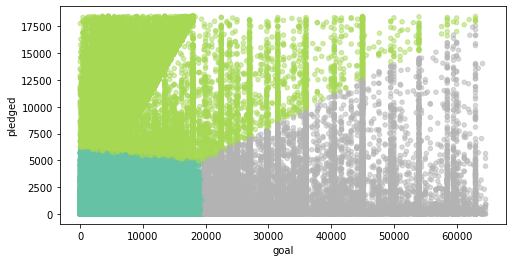

In [45]:
data_final.plot(kind="scatter",
                                x="goal",
                                y="pledged",
                                c="Cluster ID",
                                cmap="Set2",        
                                alpha=0.5,
                                colorbar=False,    
                                figsize=(8,4)
                               )

# Análisis del Clustering

## Análisis Cluster 0

A continuación analizaremos estadísticamente aquellos proyectos que han sido agrupados en el cluster 0.

In [47]:
cluster_0 = data_final[data_final['Cluster ID'] == 0]
cluster_0. head()

,goal,pledged,Cluster ID
0,6000.0,2.0,0
3,4500.0,22.5,0
4,5220.0,0.0,0
5,900.0,1201.8,0
6,1350.0,1350.0,0


In [48]:
cluster_0.describe()

,goal,pledged,Cluster ID
count,264695.000000,264695.000000,264695.0
mean,4457.087775,975.571542,0.0
std,4235.694136,1389.098595,0.0
min,0.009000,0.000000,0.0
25%,1350.000000,18.000000,0.0
50%,3570.000000,292.500000,0.0
75%,5400.000000,1381.500000,0.0
max,19676.700000,5954.000000,0.0


De este análisis estadístico observamos que el Cluster 0 contiene los valores de 'goal' y 'pledged' mas pequeños en comparación con el resto de clusters. De forma que al Cluster 0 pertenecen aquellos proyectos que requieren una menor inversión. Además podemos ver que las medias de 'goal' y 'pledged' son 4457 y 975 respectivamente. Esto nos permite saber que aquí se encuentran mayoritariamente proyectos que no han resultado exitosos. Si nos fijamos en la distribución de los datos para el 25%-50%-75% vemos que el valor de 'pledged' permanece inferior a 'goal'.
Como conclusión en el Cluster 0 se agrupan aquellos proeyctos que han resultado no exitosos y que requerían una menor inversión.

## Análisis Cluster 1

In [49]:
cluster_1 = data_final[data_final['Cluster ID']==1]
cluster_1.head()

,goal,pledged,Cluster ID
1,13500.0,15129.0,1
13,7200.0,7605.0,1
24,13500.0,16007.4,1
35,9000.0,14759.1,1
38,9000.0,9490.5,1


In [50]:
cluster_1.describe()

,goal,pledged,Cluster ID
count,39246.000000,39246.000000,39246.0
mean,9362.511071,10213.811023,1.0
std,6775.790774,3454.203602,0.0
min,0.680000,4929.300000,1.0
25%,4950.000000,7260.300000,1.0
50%,7650.000000,9423.900000,1.0
75%,11250.000000,12713.267250,1.0
max,63000.000000,18454.752000,1.0


El Cluster 1 contiene valores para 'goal' y 'pledged' superiores al Cluster 0 ya que la media es superior en ambas variables. De forma que, en general, se trata de proyectos que requieren de una mayor inversión. La variable ' goal' en este cluster abarca un rango de valores muy amplios que va desde prácticamente 0 a 63.000.
En este cluster la variable 'pledged' tiene un valor superiora la variable 'goal', de forma que en este grupo se encuentran aquellos proyectos que han resultado mayoritariamente exitosos. Al echar un vistazo al 50% de los datos vemos que la variable 'pledged' es superior a 'goal' (lo mismo ocurre para el 25%-75% de los datos).

El Cluster 1 está compuesto por aquellos proyectos exitosos que requieren de una mayor inversión en lineas generales. De hecho, si comparamos la media de los importes de 'goal' y 'pledged' del cluster 0 con el cluster 1 vemos que este último efectivamente presenta una media mayor de 7650, en comparación con la media de 3570 del Cluster 0.

## Análisis Cluster 2

In [51]:
cluster_2 = data_final[data_final['Cluster ID']==2]
cluster_2.head()

,goal,pledged,Cluster ID
2,23800.0,1459.28,2
10,26100.0,0.00,2
19,22500.0,9.00,2
20,45000.0,1.80,2
21,45000.0,418.50,2


In [52]:
cluster_2.describe()

,goal,pledged,Cluster ID
count,33567.000000,33567.000000,33567.0
mean,34799.289531,1196.953357,2.0
std,11721.533069,2150.681389,0.0
min,19500.000000,0.000000,2.0
25%,23800.000000,6.150000,2.0
50%,31500.000000,202.500000,2.0
75%,45000.000000,1325.000000,2.0
max,64665.900000,17573.400000,2.0


En el Cluster 2 se presentan los proyectos que requieren una mayor inversión en comparación con los clusters 0 y 1, ya que contiene una media para la variable 'goal' de 34800, muy por encima de las medias de los clusters anteriores.
En este cluster el valor de la variable 'pledged' es inferior a 'goal', hecho que se constata al mirar la distibución para el 25%-50%-75% de los datos. 

En el Cluster 2 se agrupan aquellos proyectos que necesitan una mayor inversión y que ha resultado no exitosos.